# Bot Lane Dynamics: Analyzing Synergy & Win Conditions in League of Legends

## 1. Project Overview
The bottom lane in League of Legends is unique because it requires the coordination of two distinct roles: the ADC (Attack Damage Carry) and the Support. This project investigates how early-game performance and champion synergy in this 2v2 lane influence the final match outcome.

Using data from the **Riot Games API** and seeded with high-ELO match IDs from **Kaggle**, this analysis focuses on two key objectives:
1.  **Early Lead Impact:** Determining if a gold advantage at 10 minutes statistically predicts a game win.
2.  **Synergy Analysis:** Identifying the strongest (and weakest) ADC + Support pairings in the current meta.

---

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from riotwatcher import LolWatcher, ApiError


API_KEY = 'xxx' # cant share my api
INPUT_FILE = 'data/match_data.csv'
OUTPUT_FILE = 'data/bot_lane_dataset.csv'
LIMIT = 10000
watcher = LolWatcher(API_KEY)

REGION_TO_ROUTING = {
    'EUW1': 'europe', 'EUN1': 'europe', 'TR1': 'europe', 'RU': 'europe',
    'NA1': 'americas', 'BR1': 'americas', 'LA1': 'americas', 'KR': 'asia',
    'OC1': 'sea', #i added all just in case but there are just EUW and EUN games here
}


def get_routing(match_id):
    prefix = match_id.split('_')[0] if '_' in match_id else 'EUW1'
    return REGION_TO_ROUTING.get(prefix, 'europe')

## 2. Data Collection & Methodology

### Data Sources
* **Seed Data:** A dataset of high-ELO match IDs (Emerald+) from the 2024/2025 season (Source: Kaggle).
* **Enrichment:** We query the **Riot Games API** (`match-v5` and `timeline-v5` endpoints) to retrieve granular details that are missing from the seed data.

### The Enrichment Process
For every match ID, we perform two specific API calls:
1.  **Draft Extraction:** Identifying the specific champions played in the `BOTTOM` and `UTILITY` roles.
2.  **Timeline Analysis:** Calculating the total gold for the Blue vs. Red bot lane at exactly the **10-minute mark**.

*Note: To handle Riot's API rate limits (100 requests/2 min), we utilize the `riotwatcher` library for optimized batch processing.*

In [17]:
def get_bot_lane_details(match_id):
    routing = get_routing(match_id)

    try:
        match_detail = watcher.match.by_id(routing, match_id)
        participants = match_detail['info']['participants']
        row_data = {}
        blue_ids, red_ids = [], []

        for p in participants:
            team_prefix = 'Blue' if p['teamId'] == 100 else 'Red'
            if p['teamPosition'] == 'BOTTOM':
                row_data[f'{team_prefix}_ADC'] = p['championName']
                if p['teamId'] == 100: blue_ids.append(p['participantId'])
                else: red_ids.append(p['participantId'])
            elif p['teamPosition'] == 'UTILITY':
                row_data[f'{team_prefix}_Support'] = p['championName']
                if p['teamId'] == 100: blue_ids.append(p['participantId'])
                else: red_ids.append(p['participantId'])

        if len(blue_ids) != 2 or len(red_ids) != 2: return None
        timeline = watcher.match.timeline_by_match(routing, match_id)
        frames = timeline['info']['frames']
        if len(frames) < 11: return None

        f10 = frames[10]['participantFrames']
        blue_gold = sum(f10[str(pid)]['totalGold'] for pid in blue_ids)
        red_gold = sum(f10[str(pid)]['totalGold'] for pid in red_ids)

        row_data['Bot_Gold_Diff_10'] = blue_gold - red_gold
        return row_data

    except ApiError as err:
        if err.response.status_code == 404:
            return "NOT_FOUND"
        return None
    except Exception:
        return None


### Execution
The following block processes the match queue. It verifies champion roles (filtering out non-standard lanes), computes the gold difference, and saves the enriched dataset to `bot_lane_dataset.csv`.

In [18]:
print("🚀 Starting Data Collection")
full_df = pd.read_csv(INPUT_FILE)
subset_df = full_df.head(LIMIT)
new_data = []

for index, row in subset_df.iterrows():
        raw_id = str(row['matchId'])
        raw_id = raw_id.replace("'", "").replace('"', "").strip()

        if "match" in raw_id.lower() or not any(c.isdigit() for c in raw_id): continue

        full_id = raw_id if '_' in raw_id else f"EUW1_{raw_id}"
        result = get_bot_lane_details(full_id)

        if isinstance(result, dict):
            result['matchID'] = full_id
            result['Blue_Win'] = row.get('blueWin', row.get('blueWins', 'Unknown'))
            new_data.append(result)
            print(f"[{index+1}] Got: {result['Blue_ADC']}/{result['Blue_Support']}")
        elif result == "NOT_FOUND":
             print(f"[{index+1}] Match not found")

df = pd.DataFrame(new_data)
df.to_csv(OUTPUT_FILE, index=False)
print("Done.")

🚀 Starting Data Collection
[1] Got: Jinx/Janna
[2] Got: Jhin/Lulu
[3] Got: Ezreal/Soraka
[4] Got: Ashe/Senna
[5] Got: Kaisa/Ashe
[6] Got: Twitch/Nautilus
[7] Got: Jinx/Hwei
[8] Got: Samira/Sylas
[9] Got: Caitlyn/Ashe
[10] Got: MissFortune/Pyke
[11] Got: Caitlyn/Karma
[12] Got: Senna/Rakan
[13] Got: Veigar/Janna
[14] Got: Ashe/Taliyah
[15] Got: Xayah/Thresh
[16] Got: Ezreal/Bard
[17] Got: Sivir/Brand
[18] Got: Jhin/Xerath
[19] Got: Aphelios/Milio
[20] Got: Nilah/Alistar
[21] Got: Ezreal/Nautilus
[22] Got: Zeri/Milio
[23] Got: Draven/Blitzcrank
[24] Got: Kaisa/Lux
[25] Got: Ezreal/Yuumi
[26] Got: Jinx/Poppy
[27] Got: Jinx/Blitzcrank
[28] Got: Ezreal/Alistar
[29] Got: Varus/Nautilus
[30] Got: Ezreal/Thresh
[31] Got: Caitlyn/Xerath
[32] Got: Zeri/Yuumi
[33] Got: Sivir/Zilean
[34] Got: Zoe/Lulu
[35] Got: Samira/Elise
[36] Got: Jhin/Janna
[37] Got: Ashe/Lulu
[38] Got: Ashe/Leona
[39] Got: Zeri/Rell
[40] Got: Morgana/Senna
[41] Got: Zeri/Yuumi
[42] Got: Samira/Nautilus
[43] Got: Zeri/Blitzcra

## 3. Analysis: The Impact of Early Gold Leads

### Research Question 1
**"Does a gold lead at 10 minutes significantly increase the probability of winning the game?"**

To answer this, we visualize the distribution of gold differences for winning vs. losing teams.
* **Metric:** `Bot_Gold_Diff_10` (Blue Gold - Red Gold). Positive values indicate a Blue lead.
* **Hypothesis Test:** We perform a **Student's T-Test** to verify statistical significance ($p < 0.05$).

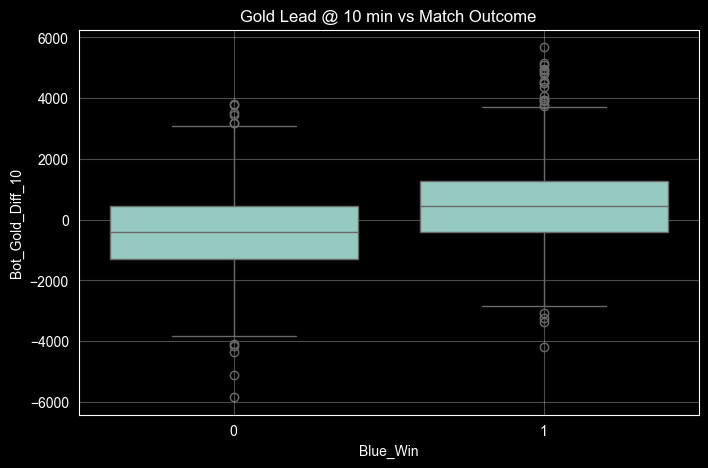

P-Value: 1.3443675265464105e-51 (Significant if < 0.05)


In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Blue_Win', y='Bot_Gold_Diff_10', data=df)
plt.title("Gold Lead @ 10 min vs Match Outcome")
plt.grid(True, alpha=0.3)
plt.show()

# Statistical Test
winners = df[df['Blue_Win'] == 1]['Bot_Gold_Diff_10']
losers = df[df['Blue_Win'] == 0]['Bot_Gold_Diff_10']
t_stat, p_val = stats.ttest_ind(winners, losers)
print(f"P-Value: {p_val} (Significant if < 0.05)")

## 4. Meta Analysis: Strongest Bot Lane Duos

### Research Question 2
**"Which ADC + Support combinations yield the highest win rates?"**

Synergy is a critical factor in the bot lane. We aggregate the data by champion pairs to identify high-performing duos.
* **Visualization:** A ranked horizontal bar chart showing the Win Rate and Games Played for the top 15 combinations.
* **Handling Sparsity:** We visualize the sample size (Games Played) to distinguish between consistent meta picks and lucky one-off wins.

In [20]:
df['Blue_Duo'] = df['Blue_ADC'] + " + " + df['Blue_Support']
duo_stats = df.groupby('Blue_Duo').agg({
    'Blue_Win': 'mean',
    'matchID': 'count',
    'Bot_Gold_Diff_10': 'mean'
}).rename(columns={'matchID': 'Games_Played', 'Blue_Win': 'Win_Rate'})
duo_stats = duo_stats[duo_stats['Games_Played'] >= 10]

print("--- TOP 5 STRONGEST DUOS ---")
print(duo_stats.sort_values('Win_Rate', ascending=False).head(5))

print("\n--- BOTTOM 5 WEAKEST DUOS ---")
print(duo_stats.sort_values('Win_Rate', ascending=True).head(5))

--- TOP 5 STRONGEST DUOS ---
                   Win_Rate  Games_Played  Bot_Gold_Diff_10
Blue_Duo                                                   
Jinx + Thresh      0.720000            25        166.760000
Jinx + Blitzcrank  0.700000            10        116.600000
Twitch + Milio     0.700000            10        657.700000
Draven + Nautilus  0.666667            12        567.916667
Ashe + Janna       0.642857            14        365.000000

--- BOTTOM 5 WEAKEST DUOS ---
                   Win_Rate  Games_Played  Bot_Gold_Diff_10
Blue_Duo                                                   
Kaisa + Braum      0.200000            10       -130.000000
Kaisa + Alistar    0.300000            10      -1145.900000
Samira + Nautilus  0.333333            12       -431.250000
Zeri + Milio       0.333333            12         66.916667
Zeri + Lulu        0.350000            20       -173.950000


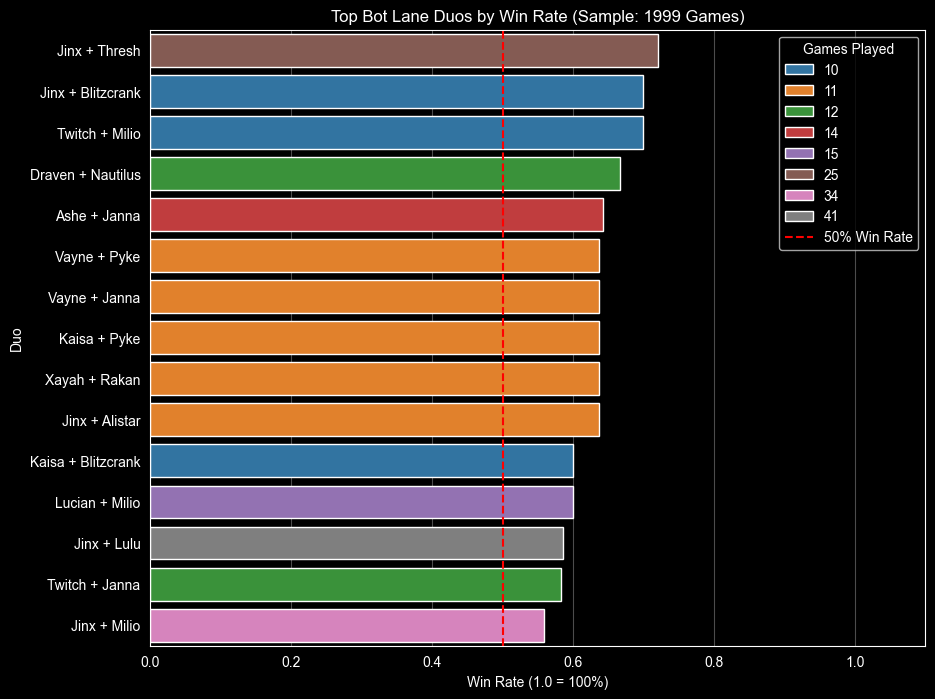

In [21]:
df['Duo'] = df['Blue_ADC'] + " + " + df['Blue_Support']
duo_stats = df.groupby('Duo').agg({
    'Blue_Win': 'mean',
    'matchID': 'count'
}).reset_index()

duo_stats.columns = ['Duo', 'Win_Rate', 'Games_Played']

min_games = 10
viz_data = duo_stats[duo_stats['Games_Played'] >= min_games].sort_values('Win_Rate', ascending=False).head(15)
plt.figure(figsize=(10, 8))

sns.barplot(
    data=viz_data,
    y='Duo',
    x='Win_Rate',
    hue='Games_Played',
    palette='tab10',
    dodge=False
)

plt.title(f"Top Bot Lane Duos by Win Rate (Sample: {len(df)} Games)")
plt.xlabel("Win Rate (1.0 = 100%)")
plt.ylabel("Duo")
plt.axvline(0.5, color='red', linestyle='--', label='50% Win Rate') # Average line
plt.legend(title="Games Played")
plt.xlim(0, 1.1)
plt.grid(axis='x', alpha=0.3)
plt.show()

## 5. Machine Learning: Supervised (Win Prediction)

### Research Question 3
**"Can we accurately predict the match winner based solely on the bot lane's gold advantage at 10 minutes?"**

To assess the predictive power of early-game performance, we train a supervised learning model.
* **Model:** **Random Forest Classifier** (Robust against overfitting and handles non-linear relationships).
* **Features:** `Bot_Gold_Diff_10` (The gold lead/deficit).
* **Target:** `Blue_Win` (1 for Win, 0 for Loss).
* **Evaluation:** We verify the model's performance using **Accuracy Score** and a **Confusion Matrix** to visualize false positives/negatives.

Random Forest Model Accuracy: 61.75%

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       224
           1       0.56      0.64      0.60       176

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.63      0.62      0.62       400



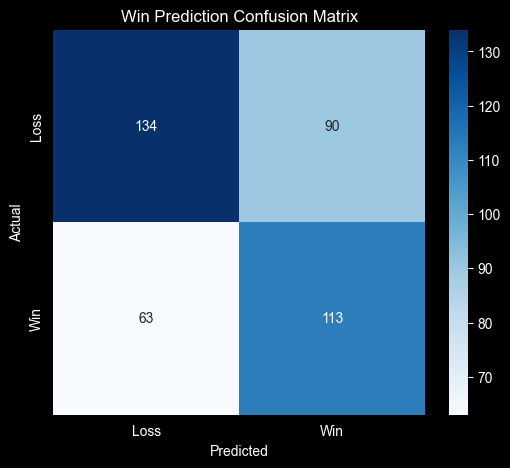

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#reshape X to be 2D array as required by sklearn
X = df[['Bot_Gold_Diff_10']]
y = df['Blue_Win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Win Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Machine Learning: Unsupervised (Performance Clustering)

### Research Question 4
**"Can we automatically classify bot lane duos into performance tiers (e.g., 'OP' vs. 'Weak') without human bias?"**

Instead of subjectively ranking champions, we use **K-Means Clustering** to find natural groupings in the data.
* **Algorithm:** **K-Means** with $k=4$ (Simulating S-Tier, A-Tier, B-Tier, C-Tier).
* **Features:** `Win_Rate` and `Bot_Gold_Diff_10`.
* **Preprocessing:** Data is normalized using `StandardScaler` to ensure Win Rate (0-1) contributes equally with Gold (0-2000).
* **Goal:** To identify if specific duos mathematically stand out as "Meta-defining" outliers.

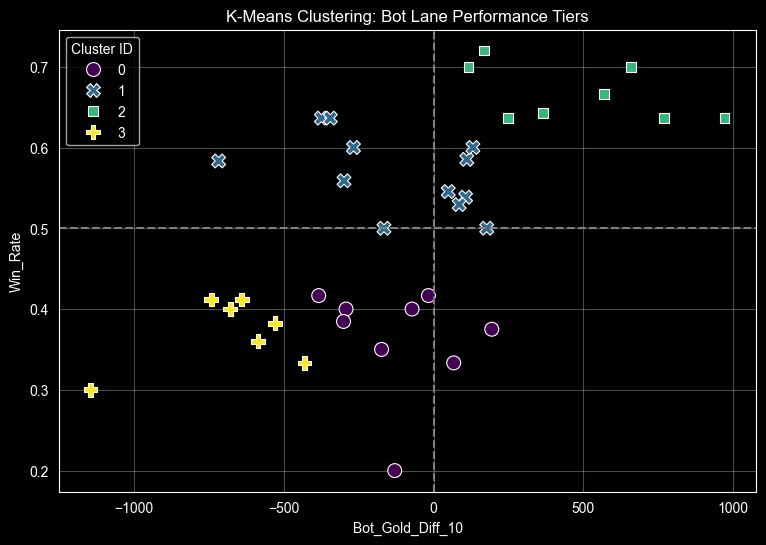

Cluster Averages (Interpretation):
         Win_Rate  Bot_Gold_Diff_10
Cluster                            
2        0.667327        482.781174
1        0.567798       -125.978301
3        0.371317       -679.340028
0        0.364031       -123.333796


In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# I recreate this variable from the main df to make sure the Gold column is there. I had problems with this
df['Blue_Duo'] = df['Blue_ADC'] + " + " + df['Blue_Support']
duo_stats = df.groupby('Blue_Duo').agg({
    'Blue_Win': 'mean',
    'matchID': 'count',
    'Bot_Gold_Diff_10': 'mean'
}).rename(columns={'matchID': 'Games_Played', 'Blue_Win': 'Win_Rate'})

duo_stats = duo_stats[duo_stats['Games_Played'] >= 10]
cluster_features = duo_stats[['Win_Rate', 'Bot_Gold_Diff_10']]


# needed to scale for k means because gold is larger than win rate
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

# k=4 for 4 Tiers (S, A, B, C)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
duo_stats['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(9, 6))
sns.scatterplot(data=duo_stats, x='Bot_Gold_Diff_10', y='Win_Rate',
                hue='Cluster', palette='viridis', s=100, style='Cluster')

plt.title('K-Means Clustering: Bot Lane Performance Tiers')
plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.legend(title='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()


print("Cluster Averages (Interpretation):")
print(duo_stats.groupby('Cluster')[['Win_Rate', 'Bot_Gold_Diff_10']].mean().sort_values('Win_Rate', ascending=False))